# Pose Estimation with TensorFlow

## Get normalized vector

In [57]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import math
import socket
import time

In [2]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
# sampleVideo = video_path + 'sampleVideo.mp4'
# basicFour = video_path + 'basic_four.mp4'
# basicTwo = video_path + 'basic_two.mp4'
# swingDiff = video_path + 'swing_diff.mp4'
# swingSame = video_path + 'swing_same.mp4'
# swingRaw = video_path + 'swingRaw.mp4'
# temporalDifficult = video_path + 'temporalDifficultRaw.mp4'
# temporalEasy = video_path + 'temporalEasyRaw.mp4'
# practice1 = video_path + 'practice1.mp4'
# practice2 = video_path + 'practice2.mp4'
swingDiff_highQual = video_path + 'swingDiff_highQual.mp4'
actionPractice = video_path + 'actionPractice.mp4'
swingFour_highQual = video_path + 'swingFour_highQual.mp4'



### Draw EDGES
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [3,5],
    [0,6],
    [1,7],
    [6,7],
    [6,8],
    [7,9],
    [8,10],
    [9,11]
]

### Vector List

# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 2
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []

    ### Loading Video File
    cap = cv2.VideoCapture(actionPractice)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        ### Variables for each frame
        BPD = []
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [0,1,2,3,4], 1)   # raw keypoints value with confidence level
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(2,12,3)

#         print(norm_vectors_only_body)
        
        
        ### Calculate cosine distance with average confidence level of two normalized vectors from each person.
        cosineDistance_with_confidence = []

        for row in range(norm_vectors_only_body.shape[1]):
            tempCosSimilarityRow = []
            tempFirstPersonVector = norm_vectors_only_body[:,row,:][0]
            tempSecondPersonVector = norm_vectors_only_body[:,row,:][1]

            cosine_similarity = np.dot(tempFirstPersonVector[:2], tempSecondPersonVector[:2]) / (np.linalg.norm(tempFirstPersonVector[:2]) * np.linalg.norm(tempSecondPersonVector[:2]))
            cosine_distance = math.sqrt(2 * (1 - cosine_similarity))
            tempAverageConfidence = (tempFirstPersonVector[2] + tempSecondPersonVector[2]) / 2
            print(cosine_similarity)
            print(cosine_distance)
            print(tempAverageConfidence)
            cosineDistance_with_confidence.append([cosine_distance, tempAverageConfidence])
            print("========")

        cosineDistance_with_confidence = np.array(cosineDistance_with_confidence)
        cosineDistance_with_confidence.reshape(2,12)
        

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....

        
        cv2.imshow('Movenet Multipose', frame)
        
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

[[[-0.99873835  0.05021592  0.91349578]
  [ 0.99051452 -0.13740855  0.75919449]
  [-0.98640501 -0.16433257  0.76489431]
  [ 0.99381417 -0.11105586  0.73900509]
  [-0.97510415 -0.22174737  0.69911039]
  [-0.08712707  0.99619722  0.93599153]
  [ 0.11368214  0.99351722  0.9497034 ]
  [-0.99988699 -0.01503309  0.97219914]
  [ 0.08447244  0.99642587  0.91590738]
  [-0.08764853  0.99615151  0.96672797]
  [ 0.04938783  0.99877965  0.85315406]
  [-0.07807258  0.99694765  0.91574228]]

 [[-0.99790162 -0.06474818  0.93060493]
  [ 0.9759528  -0.21798232  0.78825164]
  [-0.9856025  -0.1690789   0.75940245]
  [ 0.99784929 -0.06555061  0.63901365]
  [-0.99130034 -0.13161932  0.66145945]
  [-0.0999788   0.99498951  0.92752892]
  [ 0.09594136  0.99538702  0.9558121 ]
  [-0.99788785 -0.06496081  0.95273602]
  [ 0.07465324  0.99720955  0.86065751]
  [-0.10808833  0.99414128  0.93352807]
  [ 0.0609801   0.9981389   0.78084719]
  [-0.08537385  0.99634904  0.87857175]]]
[[[-0.99910784  0.04223086  0.912853

[[[-0.99945706  0.03294702  0.91352749]
  [ 0.99043351 -0.13799064  0.7735011 ]
  [-0.99303669 -0.11780516  0.76592702]
  [ 0.99242985 -0.12281308  0.75365376]
  [-0.97148299 -0.23710935  0.70800507]
  [-0.0872336   0.99618793  0.93765545]
  [ 0.11233553  0.9936704   0.94936883]
  [-0.99939591 -0.03475326  0.97349679]
  [ 0.08496848  0.99638361  0.91874039]
  [-0.09455457  0.9955197   0.96293938]
  [ 0.05089708  0.99870396  0.84892726]
  [-0.06794785  0.99768889  0.9117884 ]]

 [[-0.99804133 -0.06255808  0.92975783]
  [ 0.97314161 -0.2302074   0.77510118]
  [-0.98534399 -0.17057937  0.79234958]
  [ 0.99739844 -0.07208556  0.62918776]
  [-0.99086905 -0.13482782  0.69964921]
  [-0.09377056  0.99559385  0.92883837]
  [ 0.09076729  0.99587214  0.95732641]
  [-0.99874747 -0.05003497  0.95640683]
  [ 0.07373036  0.99727827  0.84916151]
  [-0.10770858  0.99418247  0.93721431]
  [ 0.06238729  0.99805206  0.75036263]
  [-0.08782972  0.99613553  0.87337387]]]
[[[-0.99931121  0.0371081   0.911952

[[[-0.99948329  0.03214348  0.91107285]
  [ 0.98902571 -0.14774397  0.78479135]
  [-0.99243051 -0.12280798  0.77456129]
  [ 0.99346983 -0.11409523  0.7627753 ]
  [-0.97393566 -0.2268246   0.72037005]
  [-0.09824147  0.99516261  0.93679798]
  [ 0.111346    0.99378169  0.94832933]
  [-0.99970216 -0.02440479  0.97405452]
  [ 0.08639457  0.99626106  0.92331344]
  [-0.08827886  0.99609584  0.96653235]
  [ 0.04939155  0.99877948  0.86034614]
  [-0.07737318  0.99700218  0.91121995]]

 [[-0.99751765 -0.07041698  0.92615652]
  [ 0.96445471 -0.26424825  0.7741375 ]
  [-0.98285067 -0.18440329  0.81068957]
  [ 0.99710572 -0.07602718  0.63559401]
  [-0.99269778 -0.12062861  0.74630463]
  [-0.08882791  0.99604696  0.93279934]
  [ 0.0902607   0.99591821  0.95521259]
  [-0.99765575 -0.06843296  0.96185529]
  [ 0.07319476  0.99731761  0.86076999]
  [-0.10896155  0.99404597  0.93720764]
  [ 0.05955639  0.99822497  0.77418166]
  [-0.09407022  0.99556559  0.87407082]]]
[[[-0.99971342  0.02393748  0.911456

[[[-0.99941254  0.03427058  0.8952229 ]
  [ 0.9806568  -0.19573522  0.77642035]
  [-0.98340416 -0.18142828  0.74223614]
  [ 0.99384165 -0.11080992  0.74743295]
  [-0.97847742 -0.20635404  0.68235868]
  [-0.08834823  0.99608964  0.93158543]
  [ 0.11075225  0.99384803  0.93542558]
  [-0.99951202 -0.03123564  0.97178811]
  [ 0.08522788  0.99636155  0.93145287]
  [-0.08836244  0.99608839  0.96385521]
  [ 0.05008298  0.99874508  0.86781967]
  [-0.08262671  0.99658054  0.904212  ]]

 [[-0.99813163 -0.0610996   0.9274115 ]
  [ 0.96118081 -0.27591953  0.79129159]
  [-0.97602099 -0.21767624  0.80041826]
  [ 0.99597645 -0.08961491  0.66355497]
  [-0.99523425 -0.09751266  0.75336903]
  [-0.08462641  0.99641275  0.93484855]
  [ 0.08950305  0.99598652  0.95671487]
  [-0.99534434 -0.09638271  0.96415192]
  [ 0.07330304  0.99730974  0.85980976]
  [-0.11183605  0.99372661  0.92851657]
  [ 0.05879404  0.99827009  0.78045952]
  [-0.0922182   0.99573886  0.84721118]]]


## Visualization with cosine distance & average confidence level

In [23]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
# sampleVideo = video_path + 'sampleVideo.mp4'
# basicFour = video_path + 'basic_four.mp4'
# basicTwo = video_path + 'basic_two.mp4'
# swingDiff = video_path + 'swing_diff.mp4'
# swingSame = video_path + 'swing_same.mp4'
# swingRaw = video_path + 'swingRaw.mp4'
# temporalDifficult = video_path + 'temporalDifficultRaw.mp4'
# temporalEasy = video_path + 'temporalEasyRaw.mp4'
# practice1 = video_path + 'practice1.mp4'
# practice2 = video_path + 'practice2.mp4'
swingDiff_highQual = video_path + 'swingDiff_highQual.mp4'
actionPractice = video_path + 'actionPractice.mp4'



# ### Draw EDGES
# EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
#     (5, 7): 'm',
#     (7, 9): 'm',
#     (6, 8): 'c',
#     (8, 10): 'c',
#     (5, 6): 'y',
#     (5, 11): 'm',
#     (6, 12): 'c',
#     (11, 12): 'y',
#     (11, 13): 'm',
#     (13, 15): 'm',
#     (12, 14): 'c',
#     (14, 16): 'c'
# }

### Draw NEW_EDGES
NEW_EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [3,5],
    [0,6],
    [1,7],
    [6,7],
    [6,8],
    [7,9],
    [8,10],
    [9,11]
]


# # Function to convert range of variable (map fuction)
# def map_range(value, old_min, old_max, new_min, new_max):
#     # Calculate the percentage of the value within the original range
#     percentage = (value - old_min) / (old_max - old_min)
    
#     # Calculate the value within the new range using the percentage
#     new_value = (new_max - new_min) * percentage + new_min
    
#     # Return the new value
#     return new_value


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, cosineDistance_with_confidence):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold, cosineDistance_with_confidence)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, cosineDistance_with_confidence):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(cosineDistance_with_confidence[index,0], [0.0,2.0], [0.0,255.0])    # range of consineDistance: [0,2]
        alpha_value = np.interp(cosineDistance_with_confidence[index,1], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]
    
#         color_value = map_range(cosineDistance_with_confidence[index,0],0.0,2.0,0.0,255.0)    # range of consineDistance: [0,2]
#         alpha_value = map_range(cosineDistance_with_confidence[index,1],0.0,1.0,0.0,255.0)    # range of averageConfidence: [0,1]
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 20)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 2
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []

    ### Loading Video File
    cap = cv2.VideoCapture(actionPractice)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        ### Variables for each frame
        BPD = []
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [0,1,2,3,4], 1)   # raw keypoints value with confidence level
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(2,12,3)
        
        
        ### Calculate cosine distance with average confidence level of two normalized vectors from each person.
        cosineDistance_with_confidence = []

        for row in range(norm_vectors_only_body.shape[1]):
            tempCosSimilarityRow = []
            tempFirstPersonVector = norm_vectors_only_body[:,row,:][0]
            tempSecondPersonVector = norm_vectors_only_body[:,row,:][1]

            cosine_similarity = np.dot(tempFirstPersonVector[:2], tempSecondPersonVector[:2]) / (np.linalg.norm(tempFirstPersonVector[:2]) * np.linalg.norm(tempSecondPersonVector[:2]))
            cosine_distance = math.sqrt(2 * (1 - cosine_similarity))
            tempAverageConfidence = (tempFirstPersonVector[2] + tempSecondPersonVector[2]) / 2
            cosineDistance_with_confidence.append([cosine_distance, tempAverageConfidence])

        cosineDistance_with_confidence = np.array(cosineDistance_with_confidence)
        cosineDistance_with_confidence.reshape(2,12)
        

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, NEW_EDGES, 0.1, cosineDistance_with_confidence)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....

        
        cv2.imshow('Movenet Multipose', frame)
        
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute 'copy'

In [6]:
cosineDistance_with_confidence = []

for row in range(norm_vectors_only_body.shape[1]):
    tempCosSimilarityRow = []
    tempFirstPersonVector = norm_vectors_only_body[:,row,:][0]
    tempSecondPersonVector = norm_vectors_only_body[:,row,:][1]
    
    cosine_similarity = np.dot(tempFirstPersonVector[:2], tempSecondPersonVector[:2]) / (np.linalg.norm(tempFirstPersonVector[:2]) * np.linalg.norm(tempSecondPersonVector[:2]))
    cosine_distance = math.sqrt(2 * (1 - cosine_similarity))
    tempAverageConfidence = (tempFirstPersonVector[2] + tempSecondPersonVector[2]) / 2
    print(cosine_similarity)
    print(cosine_distance)
    print(tempAverageConfidence)
    cosineDistance_with_confidence.append([cosine_distance, tempAverageConfidence])
    print("========")

cosineDistance_with_confidence = np.array(cosineDistance_with_confidence)
cosineDistance_with_confidence.reshape(2,12)
print(cosineDistance_with_confidence)

0.995451442795548
0.09537879433555468
0.9113171994686127
0.9965955812250856
0.08251568062997935
0.7838559746742249
0.999315787300913
0.03699223429551202
0.7713271975517273
0.9997731069433284
0.021302256062284208
0.7054939568042755
0.9939363818186543
0.11012373205940407
0.7178638577461243
0.9999930218041437
0.0037358254392480567
0.9332169890403748
0.999771949212223
0.021356534727197198
0.9460702240467072
0.99786924489572
0.06528024363128491
0.9679700136184692
0.9999284496525844
0.011962470264587669
0.8956313133239746
0.9997217059149738
0.02359212093162548
0.9461858868598938
0.9999619459205505
0.008723999019882637
0.8241395950317383
0.9999536474499289
0.009628348775478279
0.875711590051651
[[0.09537879 0.9113172 ]
 [0.08251568 0.78385597]
 [0.03699223 0.7713272 ]
 [0.02130226 0.70549396]
 [0.11012373 0.71786386]
 [0.00373583 0.93321699]
 [0.02135653 0.94607022]
 [0.06528024 0.96797001]
 [0.01196247 0.89563131]
 [0.02359212 0.94618589]
 [0.008724   0.8241396 ]
 [0.00962835 0.87571159]]


# Saving pandas dataframe as CSV & Drawing plots (2 people)

In [2]:
from matplotlib import pyplot as plt
from matplotlib import animation
import pandas as pd

In [24]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
# sampleVideo = video_path + 'sampleVideo.mp4'
# basicFour = video_path + 'basic_four.mp4'
# basicTwo = video_path + 'basic_two.mp4'
# swingDiff = video_path + 'swing_diff.mp4'
# swingSame = video_path + 'swing_same.mp4'
# swingRaw = video_path + 'swingRaw.mp4'
# temporalDifficult = video_path + 'temporalDifficultRaw.mp4'
# temporalEasy = video_path + 'temporalEasyRaw.mp4'
# practice1 = video_path + 'practice1.mp4'
# practice2 = video_path + 'practice2.mp4'
swingDiff_highQual = video_path + 'swingDiff_highQual.mp4'
actionPractice = video_path + 'actionPractice.mp4'



# ### Draw EDGES
# EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
#     (5, 7): 'm',
#     (7, 9): 'm',
#     (6, 8): 'c',
#     (8, 10): 'c',
#     (5, 6): 'y',
#     (5, 11): 'm',
#     (6, 12): 'c',
#     (11, 12): 'y',
#     (11, 13): 'm',
#     (13, 15): 'm',
#     (12, 14): 'c',
#     (14, 16): 'c'
# }

### Draw NEW_EDGES
NEW_EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [3,5],
    [0,6],
    [1,7],
    [6,7],
    [6,8],
    [7,9],
    [8,10],
    [9,11]
]


# # Function to convert range of variable (map fuction)
# def map_range(value, old_min, old_max, new_min, new_max):
#     # Calculate the percentage of the value within the original range
#     percentage = (value - old_min) / (old_max - old_min)
    
#     # Calculate the value within the new range using the percentage
#     new_value = (new_max - new_min) * percentage + new_min
    
#     # Return the new value
#     return new_value


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, cosineDistance_with_confidence):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold, cosineDistance_with_confidence)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, cosineDistance_with_confidence):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(cosineDistance_with_confidence[index,0], [0.0,2.0], [0.0,255.0])    # range of consineDistance: [0,2]
        alpha_value = np.interp(cosineDistance_with_confidence[index,1], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]
    
#         color_value = map_range(cosineDistance_with_confidence[index,0],0.0,2.0,0.0,255.0)    # range of consineDistance: [0,2]
#         alpha_value = map_range(cosineDistance_with_confidence[index,1],0.0,1.0,0.0,255.0)    # range of averageConfidence: [0,1]
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 20)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 2
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []
    saveCosDistance = pd.DataFrame(columns=[str(i) for i in range(12)])


    ### Loading Video File
    cap = cv2.VideoCapture(swingDiff_highQual)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        ### Variables for each frame
        BPD = []
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [0,1,2,3,4], 1)   # raw keypoints value with confidence level
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(2,12,3)
        
        
        ### Calculate cosine distance with average confidence level of two normalized vectors from each person.
        cosineDistance_with_confidence = []

        for row in range(norm_vectors_only_body.shape[1]):
            tempCosSimilarityRow = []
            tempFirstPersonVector = norm_vectors_only_body[:,row,:][0]
            tempSecondPersonVector = norm_vectors_only_body[:,row,:][1]

            cosine_similarity = np.dot(tempFirstPersonVector[:2], tempSecondPersonVector[:2]) / (np.linalg.norm(tempFirstPersonVector[:2]) * np.linalg.norm(tempSecondPersonVector[:2]))
            cosine_distance = math.sqrt(2 * (1 - cosine_similarity))
            tempAverageConfidence = (tempFirstPersonVector[2] + tempSecondPersonVector[2]) / 2
            cosineDistance_with_confidence.append([cosine_distance, tempAverageConfidence])

        cosineDistance_with_confidence = np.array(cosineDistance_with_confidence)
        cosineDistance_with_confidence.reshape(2,12)
        
        ### cosineDistance Only
        cosDistance_elicit = cosineDistance_with_confidence[:, 0] # select the first column of the array
        cosDistance_only = cosDistance_elicit.flatten() # convert the column to a 1-dim array
        
        ### Save each cosineDistance at the saveCosDistance for CSV saving
        saveCosDistance = pd.concat([saveCosDistance, pd.DataFrame([cosDistance_only], columns=saveCosDistance.columns)], ignore_index=True)

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, NEW_EDGES, 0.1, cosineDistance_with_confidence)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....

        
        cv2.imshow('Movenet Multipose', frame)
        
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute 'copy'

In [8]:
cosineDistance_with_confidence.shape

(12, 2)

In [4]:
saveCosDistance

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.006936,0.100007,0.003890,0.033697,0.039930,0.011358,0.003238,0.059492,0.002978,0.009888,0.007873,0.039840
1,0.008240,0.096342,0.011197,0.039264,0.042811,0.008768,0.003350,0.052251,0.005377,0.016125,0.008141,0.038913
2,0.002602,0.111357,0.000741,0.053633,0.024584,0.011768,0.005346,0.053098,0.004240,0.010316,0.008248,0.038705
3,0.008414,0.102548,0.006377,0.044715,0.035941,0.012800,0.003665,0.048216,0.004880,0.016869,0.009748,0.043123
4,0.005903,0.117578,0.000807,0.036950,0.034703,0.012593,0.009550,0.038518,0.011797,0.016692,0.004458,0.041925
...,...,...,...,...,...,...,...,...,...,...,...,...
1709,0.082704,1.387619,1.372307,0.857137,0.692406,0.035699,0.005367,0.077091,0.075847,0.015475,0.014113,0.004222
1710,0.025019,1.343353,1.133624,0.879857,0.562296,0.018264,0.018838,0.090456,0.183231,0.010754,0.010013,0.017461
1711,0.000307,1.146117,0.966514,0.776330,0.478148,0.010310,0.017786,0.046985,0.125983,0.023846,0.025224,0.020338
1712,0.038325,1.006015,0.878997,0.799215,0.448316,0.024541,0.006215,0.019077,0.180816,0.017432,0.008221,0.126575


In [5]:
### Save the csv from the dataframe(saveBPD)
# CHANGE THE FILE NAME!!!
saveCosDistance.to_csv('../../data/csv/cosDistancetest_actionPractice.csv', index=False)

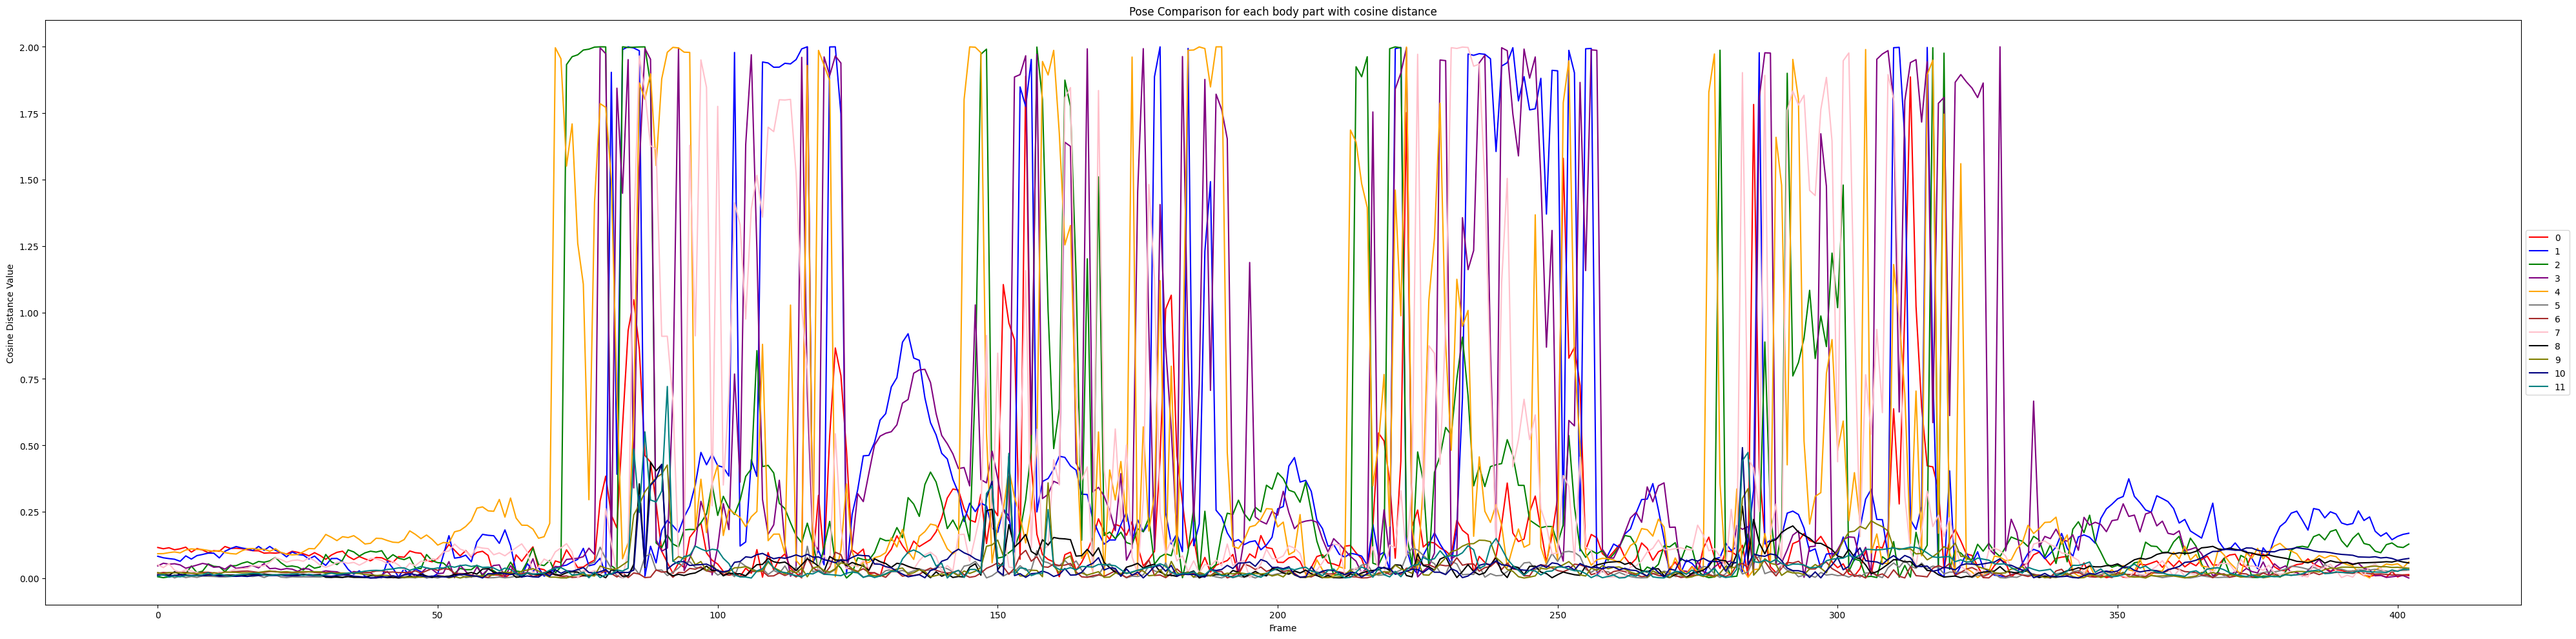

In [38]:
# Draw plot
import pandas as pd
import matplotlib.pyplot as plt

# create a sample dataframe
# data = pd.DataFrame({'col1': [1, 2, 3, 4, 5], 'col2': [2, 4, 6, 8, 10], 'col3': [3, 6, 9, 12, 15], 
#                      'col4': [4, 8, 12, 16, 20], 'col5': [5, 10, 15, 20, 25], 'col6': [6, 12, 18, 24, 30],
#                      'col7': [7, 14, 21, 28, 35], 'col8': [8, 16, 24, 32, 40], 'col9': [9, 18, 27, 36, 45], 
#                      'col10': [10, 20, 30, 40, 50], 'col11': [11, 22, 33, 44, 55], 'col12': [12, 24, 36, 48, 60]})

# plot the lines with different colors
plt.figure(figsize=(40,10))
plt.plot(saveCosDistance.index, saveCosDistance['0'], color='red', label='0')
plt.plot(saveCosDistance.index, saveCosDistance['1'], color='blue', label='1')
plt.plot(saveCosDistance.index, saveCosDistance['2'], color='green', label='2')
plt.plot(saveCosDistance.index, saveCosDistance['3'], color='purple', label='3')
plt.plot(saveCosDistance.index, saveCosDistance['4'], color='orange', label='4')
plt.plot(saveCosDistance.index, saveCosDistance['5'], color='grey', label='5')
plt.plot(saveCosDistance.index, saveCosDistance['6'], color='brown', label='6')
plt.plot(saveCosDistance.index, saveCosDistance['7'], color='pink', label='7')
plt.plot(saveCosDistance.index, saveCosDistance['8'], color='black', label='8')
plt.plot(saveCosDistance.index, saveCosDistance['9'], color='olive', label='9')
plt.plot(saveCosDistance.index, saveCosDistance['10'], color='navy', label='10')
plt.plot(saveCosDistance.index, saveCosDistance['11'], color='teal', label='11')

# set the title, x-axis label, y-axis label and legend
plt.title('Pose Comparison for each body part with cosine distance')
plt.xlabel('Frame')
plt.ylabel('Cosine Distance Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# save as pdf file
plt.tight_layout()
plt.savefig("cosDistancetest_swingTwo_.pdf")

# display the plot
plt.show()

# Visualization with cosine distance & average confidence level (> 2 people)

In [58]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
# sampleVideo = video_path + 'sampleVideo.mp4'
# basicFour = video_path + 'basic_four.mp4'
# basicTwo = video_path + 'basic_two.mp4'
# swingDiff = video_path + 'swing_diff.mp4'
# swingSame = video_path + 'swing_same.mp4'
# swingRaw = video_path + 'swingRaw.mp4'
# temporalDifficult = video_path + 'temporalDifficultRaw.mp4'
# temporalEasy = video_path + 'temporalEasyRaw.mp4'
# practice1 = video_path + 'practice1.mp4'
# practice2 = video_path + 'practice2.mp4'
swingDiff_highQual = video_path + 'swingDiff_highQual.mp4'
actionPractice = video_path + 'actionPractice.mp4'
swingFour_highQual = video_path + 'swingFour_highQual.mp4'


# ### Draw EDGES
# EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
#     (5, 7): 'm',
#     (7, 9): 'm',
#     (6, 8): 'c',
#     (8, 10): 'c',
#     (5, 6): 'y',
#     (5, 11): 'm',
#     (6, 12): 'c',
#     (11, 12): 'y',
#     (11, 13): 'm',
#     (13, 15): 'm',
#     (12, 14): 'c',
#     (14, 16): 'c'
# }

### Draw NEW_EDGES
NEW_EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [3,5],
    [0,6],
    [1,7],
    [6,7],
    [6,8],
    [7,9],
    [8,10],
    [9,11]
]


# # Function to convert range of variable (map fuction)
# def map_range(value, old_min, old_max, new_min, new_max):
#     # Calculate the percentage of the value within the original range
#     percentage = (value - old_min) / (old_max - old_min)
    
#     # Calculate the value within the new range using the percentage
#     new_value = (new_max - new_min) * percentage + new_min
    
#     # Return the new value
#     return new_value


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, cosineDistance_with_confidence):
    for idx, person in enumerate(keypoints_with_scores):
        draw_connections(frame, person, edges, confidence_threshold, cosineDistance_with_confidence[idx])
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, cosineDistance_with_confidence):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(cosineDistance_with_confidence[index,0], [0.0,2.0], [0.0,255.0])    # range of consineDistance: [0,2]
        alpha_value = np.interp(cosineDistance_with_confidence[index,1], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]
    
#         color_value = map_range(cosineDistance_with_confidence[index,0],0.0,2.0,0.0,255.0)    # range of consineDistance: [0,2]
#         alpha_value = map_range(cosineDistance_with_confidence[index,1],0.0,1.0,0.0,255.0)    # range of averageConfidence: [0,1]
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 20)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 4
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []

    ### Loading Video File
    cap = cv2.VideoCapture(swingFour_highQual)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        ### Variables for each frame
        BPD = []
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
        
        ### Sorting for keypoints_with_scores
        # Sort with Y direction (sort by values in (:,0,0))
        sorted_arr = keypoints_with_scores[np.argsort(keypoints_with_scores[:,0,0])]

        # Sort with X direction (split into two (2,12,3) arrays, sort by (:0,1), and put them back together)
        split_arr = np.split(sorted_arr, 2)
        sorted_split_arr = [np.array(sorted(sub_arr, key=lambda x: x[0,1])) for sub_arr in split_arr]
        result_arr = np.concatenate(sorted_split_arr)
        keypoints_with_scores = result_arr
        
        ### Key points only body
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [0,1,2,3,4], 1)   # raw keypoints value with confidence level (remove facial part)
        

        
        
        
        ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(numberOfPeople,12,3)
        
        
        ### Calculate cosine distance with average confidence level of two normalized vectors from each person.
        cosineDistance_with_confidence = []
        
        # compare with instructor (norm_vectors_only_body[0])
        for person in range(1, norm_vectors_only_body.shape[0]):
            tempPerson = []
            for row in range(norm_vectors_only_body.shape[1]):
                tempCosSimilarityRow = []
                tempInstructorVector = norm_vectors_only_body[0,row,:]
                tempStudentVector = norm_vectors_only_body[person,row,:]

                cosine_similarity = np.dot(tempInstructorVector[:2], tempStudentVector[:2]) / (np.linalg.norm(tempInstructorVector[:2]) * np.linalg.norm(tempStudentVector[:2]))
                cosine_distance = math.sqrt(2 * (1 - cosine_similarity))
                tempAverageConfidence = (tempInstructorVector[2] + tempStudentVector[2]) / 2
                tempPerson.append([cosine_distance, tempAverageConfidence])
            cosineDistance_with_confidence.append(tempPerson)

        cosineDistance_with_confidence = np.array(cosineDistance_with_confidence)
        #cosineDistance_with_confidence.reshape(numberOfPeople-1,2,12)
        

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores[1:], NEW_EDGES, 0.1, cosineDistance_with_confidence)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....

        
        cv2.imshow('Movenet Multipose', frame)
        
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [55]:
cosineDistance_with_confidence

array([[[1.02448818, 0.41690147],
        [1.74299348, 0.42871841],
        [0.03421481, 0.40833638],
        [1.94714411, 0.40181994],
        [0.07235124, 0.38005611],
        [1.61478571, 0.43996224],
        [1.15337432, 0.42335391],
        [0.33835727, 0.44641467],
        [1.35339462, 0.44329114],
        [0.97910747, 0.4465665 ],
        [0.22454019, 0.43568414],
        [1.03896533, 0.45016611]],

       [[1.06120451, 0.43816969],
        [1.88988189, 0.437395  ],
        [0.06103179, 0.40030322],
        [1.90908787, 0.41239983],
        [0.0491564 , 0.38488069],
        [1.61470766, 0.45065427],
        [1.17069091, 0.43729192],
        [0.33107293, 0.44977655],
        [1.37493609, 0.45329494],
        [0.97352765, 0.46409882],
        [0.18973451, 0.46736505],
        [1.04980319, 0.45528383]],

       [[0.97784643, 0.43869034],
        [1.7783078 , 0.41909709],
        [0.12044649, 0.44452641],
        [1.93444087, 0.39998281],
        [0.24148661, 0.42745021],
        [1

In [56]:
cosineDistance_with_confidence.reshape(numberOfPeople-1,2,12)
cosineDistance_with_confidence

array([[[1.02448818, 0.41690147],
        [1.74299348, 0.42871841],
        [0.03421481, 0.40833638],
        [1.94714411, 0.40181994],
        [0.07235124, 0.38005611],
        [1.61478571, 0.43996224],
        [1.15337432, 0.42335391],
        [0.33835727, 0.44641467],
        [1.35339462, 0.44329114],
        [0.97910747, 0.4465665 ],
        [0.22454019, 0.43568414],
        [1.03896533, 0.45016611]],

       [[1.06120451, 0.43816969],
        [1.88988189, 0.437395  ],
        [0.06103179, 0.40030322],
        [1.90908787, 0.41239983],
        [0.0491564 , 0.38488069],
        [1.61470766, 0.45065427],
        [1.17069091, 0.43729192],
        [0.33107293, 0.44977655],
        [1.37493609, 0.45329494],
        [0.97352765, 0.46409882],
        [0.18973451, 0.46736505],
        [1.04980319, 0.45528383]],

       [[0.97784643, 0.43869034],
        [1.7783078 , 0.41909709],
        [0.12044649, 0.44452641],
        [1.93444087, 0.39998281],
        [0.24148661, 0.42745021],
        [1

In [51]:
norm_vectors_only_body

array([[[-0.99468267, -0.10298715,  0.85963011],
        [ 0.88370466,  0.46804497,  0.8746919 ],
        [-0.86987919, -0.49326482,  0.85153437],
        [ 0.87784833,  0.47893876,  0.85722125],
        [-0.80233955, -0.59686792,  0.77493507],
        [-0.09037268,  0.99590802,  0.89539319],
        [ 0.0748256 ,  0.99719661,  0.9000504 ],
        [-0.99798822, -0.06340051,  0.93581355],
        [ 0.07913701,  0.99686378,  0.91363299],
        [ 0.0206763 ,  0.99978626,  0.90921295],
        [ 0.01296891,  0.99991596,  0.8685323 ],
        [ 0.11209313,  0.99369764,  0.86086023]],

       [[-0.99428266,  0.10678041,  0.84351695],
        [ 0.99677092, -0.08029845,  0.82856333],
        [-0.99960119,  0.02823964,  0.8249687 ],
        [ 0.99012637, -0.1401778 ,  0.789258  ],
        [-0.9798218 , -0.19987313,  0.85131764],
        [-0.09208142,  0.99575144,  0.89081621],
        [ 0.06309967,  0.99800724,  0.86208355],
        [-0.98680043, -0.16194113,  0.90938282],
        [ 0.029687

In [48]:
norm_vectors_only_body[0,0,:]

array([0.99309605, 0.11730409, 0.78914964])

# Saving pandas dataframe as CSV & Drawing plots (> 2 people)

In [59]:
from matplotlib import pyplot as plt
from matplotlib import animation
import pandas as pd

In [62]:
###
numberOfPeople = 4
num_bodyPart = 12
landmarks = []
for person in range(1, numberOfPeople):
    for coords in range(0, num_bodyPart):
        landmarks += ['{}th person - {}th body-part'.format(person, coords)]

In [63]:
landmarks

['1th person - 0th body-part',
 '1th person - 1th body-part',
 '1th person - 2th body-part',
 '1th person - 3th body-part',
 '1th person - 4th body-part',
 '1th person - 5th body-part',
 '1th person - 6th body-part',
 '1th person - 7th body-part',
 '1th person - 8th body-part',
 '1th person - 9th body-part',
 '1th person - 10th body-part',
 '1th person - 11th body-part',
 '2th person - 0th body-part',
 '2th person - 1th body-part',
 '2th person - 2th body-part',
 '2th person - 3th body-part',
 '2th person - 4th body-part',
 '2th person - 5th body-part',
 '2th person - 6th body-part',
 '2th person - 7th body-part',
 '2th person - 8th body-part',
 '2th person - 9th body-part',
 '2th person - 10th body-part',
 '2th person - 11th body-part',
 '3th person - 0th body-part',
 '3th person - 1th body-part',
 '3th person - 2th body-part',
 '3th person - 3th body-part',
 '3th person - 4th body-part',
 '3th person - 5th body-part',
 '3th person - 6th body-part',
 '3th person - 7th body-part',
 '3t

In [ ]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
# sampleVideo = video_path + 'sampleVideo.mp4'
# basicFour = video_path + 'basic_four.mp4'
# basicTwo = video_path + 'basic_two.mp4'
# swingDiff = video_path + 'swing_diff.mp4'
# swingSame = video_path + 'swing_same.mp4'
# swingRaw = video_path + 'swingRaw.mp4'
# temporalDifficult = video_path + 'temporalDifficultRaw.mp4'
# temporalEasy = video_path + 'temporalEasyRaw.mp4'
# practice1 = video_path + 'practice1.mp4'
# practice2 = video_path + 'practice2.mp4'
swingDiff_highQual = video_path + 'swingDiff_highQual.mp4'
actionPractice = video_path + 'actionPractice.mp4'
swingFour_highQual = video_path + 'swingFour_highQual.mp4'


# ### Draw EDGES
# EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
#     (5, 7): 'm',
#     (7, 9): 'm',
#     (6, 8): 'c',
#     (8, 10): 'c',
#     (5, 6): 'y',
#     (5, 11): 'm',
#     (6, 12): 'c',
#     (11, 12): 'y',
#     (11, 13): 'm',
#     (13, 15): 'm',
#     (12, 14): 'c',
#     (14, 16): 'c'
# }

### Draw NEW_EDGES
NEW_EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [3,5],
    [0,6],
    [1,7],
    [6,7],
    [6,8],
    [7,9],
    [8,10],
    [9,11]
]



# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, cosineDistance_with_confidence):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold, cosineDistance_with_confidence)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, cosineDistance_with_confidence):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(cosineDistance_with_confidence[index,0], [0.0,2.0], [0.0,255.0])    # range of consineDistance: [0,2]
        alpha_value = np.interp(cosineDistance_with_confidence[index,1], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]
    
#         color_value = map_range(cosineDistance_with_confidence[index,0],0.0,2.0,0.0,255.0)    # range of consineDistance: [0,2]
#         alpha_value = map_range(cosineDistance_with_confidence[index,1],0.0,1.0,0.0,255.0)    # range of averageConfidence: [0,1]
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 20)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 2
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []
    saveCosDistance = pd.DataFrame(columns=[landmarks])


    ### Loading Video File
    cap = cv2.VideoCapture(swingFour_highQual)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        ### Variables for each frame
        BPD = []
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [0,1,2,3,4], 1)   # raw keypoints value with confidence level
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(2,12,3)
        
        
        ### Calculate cosine distance with average confidence level of two normalized vectors from each person.
        cosineDistance_with_confidence = []

        for row in range(norm_vectors_only_body.shape[1]):
            tempCosSimilarityRow = []
            tempFirstPersonVector = norm_vectors_only_body[:,row,:][0]
            tempSecondPersonVector = norm_vectors_only_body[:,row,:][1]

            cosine_similarity = np.dot(tempFirstPersonVector[:2], tempSecondPersonVector[:2]) / (np.linalg.norm(tempFirstPersonVector[:2]) * np.linalg.norm(tempSecondPersonVector[:2]))
            cosine_distance = math.sqrt(2 * (1 - cosine_similarity))
            tempAverageConfidence = (tempFirstPersonVector[2] + tempSecondPersonVector[2]) / 2
            cosineDistance_with_confidence.append([cosine_distance, tempAverageConfidence])

        cosineDistance_with_confidence = np.array(cosineDistance_with_confidence)
        cosineDistance_with_confidence.reshape(2,12)
        
        ### cosineDistance Only
        cosDistance_elicit = cosineDistance_with_confidence[:, 0] # select the first column of the array
        cosDistance_only = cosDistance_elicit.flatten() # convert the column to a 1-dim array
        
        ### Save each cosineDistance at the saveCosDistance for CSV saving
        saveCosDistance = pd.concat([saveCosDistance, pd.DataFrame([cosDistance_only], columns=saveCosDistance.columns)], ignore_index=True)

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, NEW_EDGES, 0.1, cosineDistance_with_confidence)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....

        
        cv2.imshow('Movenet Multipose', frame)
        
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
# sampleVideo = video_path + 'sampleVideo.mp4'
# basicFour = video_path + 'basic_four.mp4'
# basicTwo = video_path + 'basic_two.mp4'
# swingDiff = video_path + 'swing_diff.mp4'
# swingSame = video_path + 'swing_same.mp4'
# swingRaw = video_path + 'swingRaw.mp4'
# temporalDifficult = video_path + 'temporalDifficultRaw.mp4'
# temporalEasy = video_path + 'temporalEasyRaw.mp4'
# practice1 = video_path + 'practice1.mp4'
# practice2 = video_path + 'practice2.mp4'
swingDiff_highQual = video_path + 'swingDiff_highQual.mp4'
actionPractice = video_path + 'actionPractice.mp4'
swingFour_highQual = video_path + 'swingFour_highQual.mp4'


# ### Draw EDGES
# EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
#     (5, 7): 'm',
#     (7, 9): 'm',
#     (6, 8): 'c',
#     (8, 10): 'c',
#     (5, 6): 'y',
#     (5, 11): 'm',
#     (6, 12): 'c',
#     (11, 12): 'y',
#     (11, 13): 'm',
#     (13, 15): 'm',
#     (12, 14): 'c',
#     (14, 16): 'c'
# }

### Draw NEW_EDGES
NEW_EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [3,5],
    [0,6],
    [1,7],
    [6,7],
    [6,8],
    [7,9],
    [8,10],
    [9,11]
]


# # Function to convert range of variable (map fuction)
# def map_range(value, old_min, old_max, new_min, new_max):
#     # Calculate the percentage of the value within the original range
#     percentage = (value - old_min) / (old_max - old_min)
    
#     # Calculate the value within the new range using the percentage
#     new_value = (new_max - new_min) * percentage + new_min
    
#     # Return the new value
#     return new_value


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, cosineDistance_with_confidence):
    for idx, person in enumerate(keypoints_with_scores):
        draw_connections(frame, person, edges, confidence_threshold, cosineDistance_with_confidence[idx])
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, cosineDistance_with_confidence):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(cosineDistance_with_confidence[index,0], [0.0,2.0], [0.0,255.0])    # range of consineDistance: [0,2]
        alpha_value = np.interp(cosineDistance_with_confidence[index,1], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]
    
#         color_value = map_range(cosineDistance_with_confidence[index,0],0.0,2.0,0.0,255.0)    # range of consineDistance: [0,2]
#         alpha_value = map_range(cosineDistance_with_confidence[index,1],0.0,1.0,0.0,255.0)    # range of averageConfidence: [0,1]
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 20)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 4
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []

    saveCosDistance = pd.DataFrame(columns=[landmarks])


    ### Loading Video File
    cap = cv2.VideoCapture(swingFour_highQual)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        ### Variables for each frame
        BPD = []
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
        
        ### Sorting for keypoints_with_scores
        # Sort with Y direction (sort by values in (:,0,0))
        sorted_arr = keypoints_with_scores[np.argsort(keypoints_with_scores[:,0,0])]

        # Sort with X direction (split into two (2,12,3) arrays, sort by (:0,1), and put them back together)
        split_arr = np.split(sorted_arr, 2)
        sorted_split_arr = [np.array(sorted(sub_arr, key=lambda x: x[0,1])) for sub_arr in split_arr]
        result_arr = np.concatenate(sorted_split_arr)
        keypoints_with_scores = result_arr
        
        ### Key points only body
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [0,1,2,3,4], 1)   # raw keypoints value with confidence level (remove facial part)
        

        
        
        
        ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(numberOfPeople,12,3)
        
        
        ### Calculate cosine distance with average confidence level of two normalized vectors from each person.
        cosineDistance_with_confidence = []
        
        # compare with instructor (norm_vectors_only_body[0])
        for person in range(1, norm_vectors_only_body.shape[0]):
            tempPerson = []
            for row in range(norm_vectors_only_body.shape[1]):
                tempCosSimilarityRow = []
                tempInstructorVector = norm_vectors_only_body[0,row,:]
                tempStudentVector = norm_vectors_only_body[person,row,:]

                cosine_similarity = np.dot(tempInstructorVector[:2], tempStudentVector[:2]) / (np.linalg.norm(tempInstructorVector[:2]) * np.linalg.norm(tempStudentVector[:2]))
                cosine_distance = math.sqrt(2 * (1 - cosine_similarity))
                tempAverageConfidence = (tempInstructorVector[2] + tempStudentVector[2]) / 2
                tempPerson.append([cosine_distance, tempAverageConfidence])
            cosineDistance_with_confidence.append(tempPerson)

        cosineDistance_with_confidence = np.array(cosineDistance_with_confidence)
        #cosineDistance_with_confidence.reshape(numberOfPeople-1,2,12)
        

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores[1:], NEW_EDGES, 0.1, cosineDistance_with_confidence)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....

        
        cv2.imshow('Movenet Multipose', frame)
        
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
### Save the csv from the dataframe(saveBPD)
# CHANGE THE FILE NAME!!!
saveCosDistance.to_csv('../../data/csv/cosDistancetest_actionPractice____.csv', index=False)

In [ ]:
# Draw plot
import pandas as pd
import matplotlib.pyplot as plt

# create a sample dataframe
# data = pd.DataFrame({'col1': [1, 2, 3, 4, 5], 'col2': [2, 4, 6, 8, 10], 'col3': [3, 6, 9, 12, 15], 
#                      'col4': [4, 8, 12, 16, 20], 'col5': [5, 10, 15, 20, 25], 'col6': [6, 12, 18, 24, 30],
#                      'col7': [7, 14, 21, 28, 35], 'col8': [8, 16, 24, 32, 40], 'col9': [9, 18, 27, 36, 45], 
#                      'col10': [10, 20, 30, 40, 50], 'col11': [11, 22, 33, 44, 55], 'col12': [12, 24, 36, 48, 60]})

# plot the lines with different colors
plt.figure(figsize=(40,10))
plt.plot(saveCosDistance.index, saveCosDistance['0'], color='red', label='0')
plt.plot(saveCosDistance.index, saveCosDistance['1'], color='blue', label='1')
plt.plot(saveCosDistance.index, saveCosDistance['2'], color='green', label='2')
plt.plot(saveCosDistance.index, saveCosDistance['3'], color='purple', label='3')
plt.plot(saveCosDistance.index, saveCosDistance['4'], color='orange', label='4')
plt.plot(saveCosDistance.index, saveCosDistance['5'], color='grey', label='5')
plt.plot(saveCosDistance.index, saveCosDistance['6'], color='brown', label='6')
plt.plot(saveCosDistance.index, saveCosDistance['7'], color='pink', label='7')
plt.plot(saveCosDistance.index, saveCosDistance['8'], color='black', label='8')
plt.plot(saveCosDistance.index, saveCosDistance['9'], color='olive', label='9')
plt.plot(saveCosDistance.index, saveCosDistance['10'], color='navy', label='10')
plt.plot(saveCosDistance.index, saveCosDistance['11'], color='teal', label='11')

# set the title, x-axis label, y-axis label and legend
plt.title('Pose Comparison for each body part with cosine distance')
plt.xlabel('Frame')
plt.ylabel('Cosine Distance Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# save as pdf file
plt.tight_layout()
plt.savefig("cosDistancetest_swingTwo___.pdf")

# display the plot
plt.show()